<img src="chess_pos.png">

<center><h1 style="font-size: 40px">Evaluating Chess Positions</h1>
<h4>By Kevin Peachey and Francisco Morales</h4></center>
<hr>

## Introduction

We love Chess, as do many other people. So for this tutorial, we are taking our own crack at a predictive chess model. We believe that we can extrapolate some interesting data from online chess games, especially from the move list, and build our own chess engine. 

On Kaggle, we found a dataset of around 20k online chess matches. We are going to tidy this data, perform some exploratory analysis on the features of the matches, and create a model that predicts the chances of winning for a given board position. We will finally compare our model to another one using traditional weights on each of the pieces. 

### Imports

In [2]:
!pip install chess
!pip install pandas

     |████████████████████████████████| 141 kB 5.3 MB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
import chess
import random
import chess.svg
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

## Dataset

The dataset we'll be using is a .csv of ~20,000 games played on lichess.org, a free chess website. The fields of interest to us are the ratings of the players, which player won, and the moves, which will allow us to reconstruct the games and evaluate positions that come up. It's worth noting that there are no null values in the dataset, which will simplify the data-cleaning process.

In [4]:
df = pd.read_csv("games.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


## Data Cleaning

### Outlier games

Since this dataset is a collection of games that were played online, there may be games that ended for reasons outside of the game itself. For instance, a player may resign if they have an obligation in the real world to attend to, irrespective of the current board position. Games may also end if a player loses connection during the match. These games introduce noise into our analysis, since their outcomes may have nothing to do with the moves played.

While there is no way to detect all of these games, we can use domain knowledge to elimate some of them. For instance, sometimes a player will leave an online match before they play any moves because they started a new game accidentally. Since it is very rare for a chess game to end after few moves, games that have only a few moves are most likely outliers in which a player had to leave early.

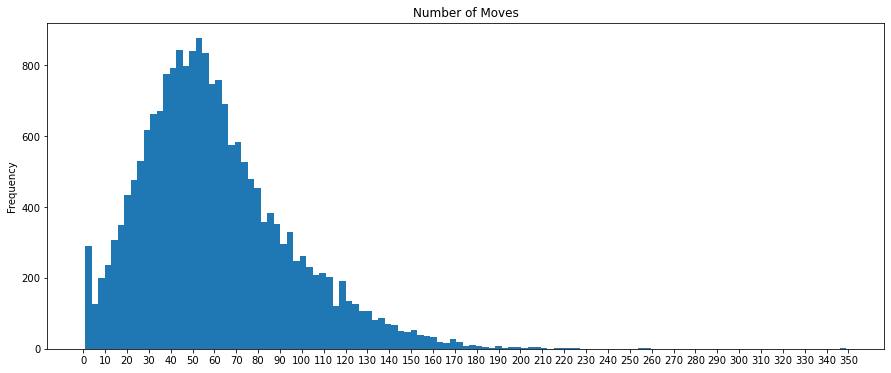

In [5]:
df['turns'].plot.hist(title='Number of Moves', bins=117, figsize=(15,6), xticks=range(0,351,10))

As shown by the histogram, there are around 300 games that have 0-3 moves, which represents a local maximum. This spike around 0 suggests that it is relatively common to start a new game accidentally, since there are many more games with 0-3 moves than in any of the bins from 3-12 moves. We will remove these 300 games from the dataset since it is almost certain that they ended due to external reasons.

In [6]:
df.drop(df[df['turns'] <= 3].index, inplace=True)

Here's what the turn data looks like after the omission.

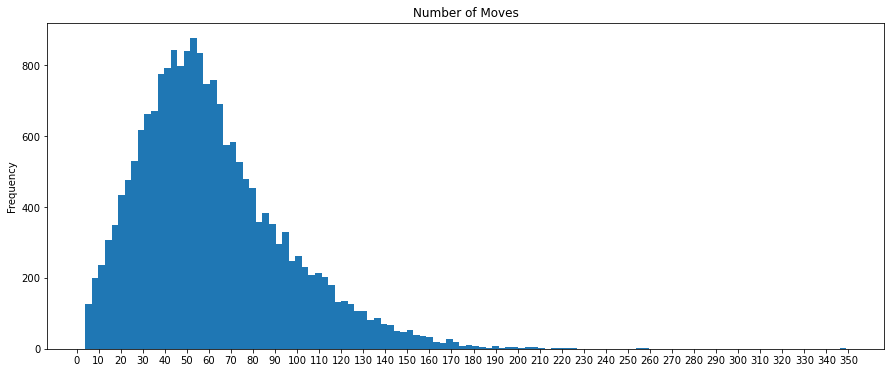

In [7]:
df['turns'].plot.hist(title='Number of Moves', bins=116, figsize=(15,6), xticks=range(0,351,10))

## Exploratory Data Analysis

### Material advantage

Material advantage is an intuitive measure of success in a chess match. Of course, material advantage isn't everything but it would be significant to compare the average material advantage (white vs black) with winning percentage. This will show us if having a higher material advantage over the course of the match is a good indicator of winning the match.

In [8]:
adv_df = df.copy()[['turns', 'winner', 'moves']]

In [9]:
# This function will calculate the avarage material advantage throughout the entire match 
def calc_adv(moves):
    # white and black
    takes = [16, 16]
    
    total_diff = 0 
    
    # Iterate through each turn
    for (i, move) in enumerate(moves.split(" ")):
        # 0 = white, 1 = black
        color = i % 2
        
        # Find if someone took in this turn
        did_take = 'x' in move
        if did_take:
            takes[(color + 1) % 2] -= 1
        
        # Add up differences
        total_diff += takes[0] - takes[1]
    
    # Average 
    return total_diff / len(moves)

Here, we calculate the average material advantage for each game. A negative value is an overall material advantage for black.

In [10]:
adv_df['avg_adv'] = [calc_adv(moves) for moves in adv_df['moves']]
adv_df.head(5)

,turns,winner,moves,avg_adv
0,13,white,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,0.200000
1,16,black,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,-0.015625
2,61,white,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,1.299213
3,61,white,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,0.293233
4,95,white,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,0.445570


This is the distribution of average material advantage in the dataset. As we can see, it seems to be symmetrically distributed around 0.

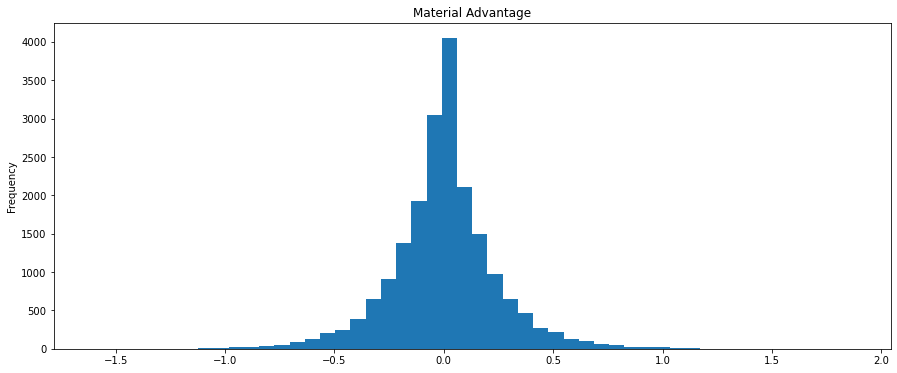

In [11]:
adv_df['avg_adv'].plot.hist(title='Material Advantage', bins=50, figsize=(15,6))

Next, we can separate the continuous value of material advantage into 20 distinct bins. Then, those bins will be associated with the frequency of wins so we can determine what the correlation is between overall material advantage and win ratio.

In [12]:
adv_df['adv_bin'] = pd.qcut(adv_df['avg_adv'], 20, precision=2)
adv_df['win_ratio'] = adv_df['winner'].replace({'black':-1, 'draw':0, 'white':1})
adv_bin_win = adv_df[['adv_bin', 'win_ratio']].groupby('adv_bin', as_index=False).mean()

Finally, we can plot the bins with their calculated win percentage. As you can see, there is a positive trend suggesting that material advantage is positively correlated with winning the match.

Text(0, 0.5, 'Win Ratio')

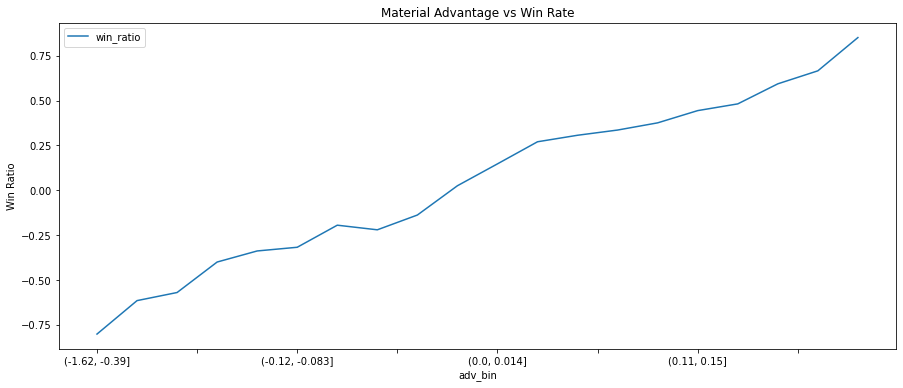

In [13]:
adv_bin_win.plot(x='adv_bin', figsize=(15,6))
plt.title("Material Advantage vs Win Rate")
plt.ylabel("Win Ratio")

This positive trend suggests that material advantage can be a significant metric in evaluating a position in chess in terms of probability of winning the match. Later on we will explore this relationship more and stratify it into specific piece advantage.

### Rating Differential

Another variable that we'll explore is the difference in rating between the two players. lichess.org uses the Glicko-2 rating system, which starts each player with a rating of 1500 and awards/removes points based on the outcomes of their matches. These rankings generally give a good indication of the skill of a player, so we'd expect that a player who has a higher ranking than their opponent is more likely to win by a margin roughly proportional to the difference in rank.

Here, we'll calculate the rating differential and get a sense of the distribution.

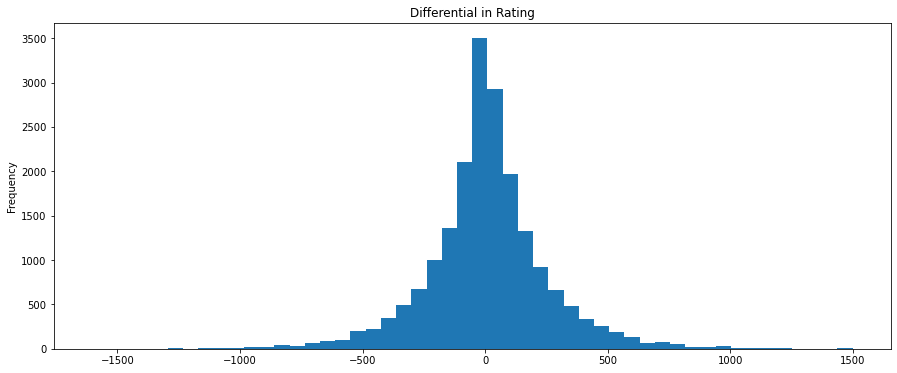

In [14]:
df['rating_diff'] = (df['white_rating']-df['black_rating'])
df['rating_diff'].plot.hist(title='Differential in Rating', bins=50, figsize=(15,6))

It appears that differential in rating is symmetrically distributed and centered around zero, meaning that, on average, players should be evenly matched. To examine the effect of this differential on the outcome of the games, we will use qcut to split this Series into equally sized bins based on value, then plot the win rates of the bins against each other.

In [15]:
df['rating_bin'] = pd.qcut(df['rating_diff'], 5)

To compute average win rate, we'll need to convert the 'winner' column from a categorical variable into a number that can be averaged. We'll encode a victory for white as +1, victory for black as -1, and a draw as 0. With this encoding, a negative average would indicate that black has a higher winning rate for that bin, and vice versa for white.

In [16]:
df['win_ratio'] = df['winner'].replace({'black':-1, 'draw':0, 'white':1})

Finally, we'll group by the rating bin and compute the average win rate.

In [17]:
df_bin = df.groupby('rating_bin').mean()
df_bin

,rated,created_at,last_move_at,turns,white_rating,black_rating,opening_ply,rating_diff,win_ratio
rating_bin,,,,,,,,,
"(-1605.001, -146.0]",0.736922,1.481953e+12,1.481954e+12,59.142785,1442.118524,1765.393985,4.737427,-323.275461,-0.481173
"(-146.0, -29.0]",0.862601,1.485796e+12,1.485797e+12,64.087551,1548.759362,1627.842611,4.867915,-79.083249,-0.126265
"(-29.0, 39.0]",0.867503,1.487997e+12,1.487998e+12,64.025094,1589.107654,1584.605521,4.903388,4.502133,0.040151
"(39.0, 162.0]",0.845003,1.483758e+12,1.483759e+12,63.092846,1645.333841,1552.122527,4.877727,93.211314,0.226535
"(162.0, 1499.0]",0.719736,1.479823e+12,1.479824e+12,56.211597,1769.795015,1425.196846,4.916328,344.598169,0.562818


Text(0, 0.5, 'Win Ratio')

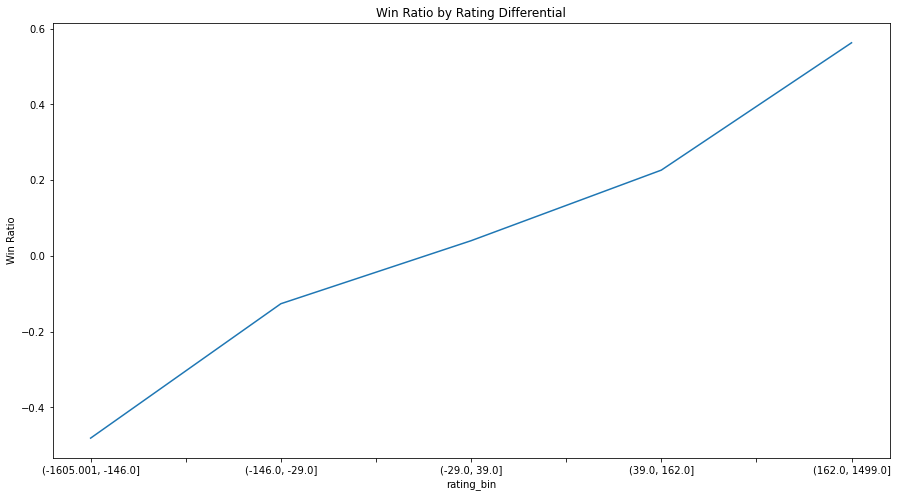

In [18]:
df_bin['win_ratio'].plot(title='Win Ratio by Rating Differential', figsize=(15,8))
plt.ylabel("Win Ratio")

As shown by the table and graph, there is a clear positive correlation between the win ratio and the rating differential between the two players. This trend makes a good deal of intuitive sense; if a player is higher rated than their opponent, they are more likely to win the match. The correlation suggests that the rating differential could be a useful variable to include in our evaluation model.

### Center Control

From prior knowledge, we know that the central four squares of the chess board play a large role in the game and that control of these squares will generally translate into an advantage. For our evaluation function, we will define center control as:
(# of central squares that white controls - # of central squares that black controls). A positive value will indicate an advantage for white and a negative one will represent an advantage for black, like the other indicators.

In [19]:
def center_control(board):
    center = [chess.D4, chess.E4, chess.D5, chess.E5]
    white_control = 0
    black_control = 0
    for sq in center:
        white_control += len(board.attackers(chess.WHITE, sq))
        black_control += len(board.attackers(chess.BLACK, sq))
    return white_control - black_control

## ML/Testing

Now that we've determined that both rating and material difference predict win rate, we will use gradient descent to create a linear regression model based on these variables. This model will then be used to predict what the outcome of a game will be based on the current position. Explicitly, the model will be of the form:

\begin{equation*}
P = A(rating_W - rating_B) + B(pawns_W - pawns_B) + C(knights_W - knights_B) + D(bishops_W - bishops_B) + E(rooks_W - rooks_B) + F(queens_W - queens_B) + G(center\_control) + H
\end{equation*}

where P is the predicted win rate for the position and A-H are constants that will be optimized through gradient descent.

### Reformatting the Data

We'll use the first half of the data to train our model, and measure the accuracy of the predictions on the second half.

In [20]:
# Splitting the data approximately in half
df_training = df.iloc[:10000,:]
df_testing = df.iloc[10001:,:]

Right now, each row in the DataFrames represents one game. In order to train a function that evaluates a single position on the board, each of these games will need to be decomposed into the positions that occur at the end of each turn. Once this has been done, each row of the new dataframes will represent a single position, with fields for the rating difference, material advantages for each piece type, and outcome of the game. With this format, the rating difference and material difference columns represent all the variable inputs to the function, and the outcome column (value from -1 to 1) will be the target prediction values for the model.

In [21]:
def expand_game(row, out_arr):
    move_list = row['moves'].split()
    board = chess.Board()
    
    i = 0
    num_turns = len(move_list)

    while (i < num_turns):
        board.push(board.parse_san(move_list[i]))
        if (i < num_turns - 1):
            board.push(board.parse_san(move_list[i+1]))
        out_arr.append([row['id'],
                 row['rating_diff'],
                 len(board.pieces(chess.PAWN,chess.WHITE)) - len(board.pieces(chess.PAWN,chess.BLACK)),
                 len(board.pieces(chess.KNIGHT,chess.WHITE)) - len(board.pieces(chess.KNIGHT,chess.BLACK)),
                 len(board.pieces(chess.BISHOP,chess.WHITE)) - len(board.pieces(chess.BISHOP,chess.BLACK)),
                 len(board.pieces(chess.ROOK,chess.WHITE)) - len(board.pieces(chess.ROOK,chess.BLACK)),
                 len(board.pieces(chess.QUEEN,chess.WHITE)) - len(board.pieces(chess.QUEEN,chess.BLACK)),
                 center_control(board),
                 row['win_ratio']
                ])
        i += 2

The expand_game function above takes a game (a row in the DataFrame) and outputs an array with information of interest for each turn in the game. This information is stored in the output array given as a parameter. Each turn in the game has a row in the array with the material information at that position, which is needed for the regression model. This function is applied to every row in the DataFrame, and the resultant array is used to create a new DataFrame in the format that we need.

In [22]:
cols = ['id', 'rating_diff','pawn_adv','knight_adv','bishop_adv','rook_adv','queen_adv','center_control','win_code']

# The expansion function is applied to each half of the data
move_info = []
df_training.apply(lambda row: expand_game(row, move_info), axis=1)
df_training_pos = pd.DataFrame(move_info, columns=cols)

move_info = []
df_testing.apply(lambda row: expand_game(row, move_info), axis=1)
df_testing_pos = pd.DataFrame(move_info, columns=cols)

In [23]:
df_training_pos.head(10)

,id,rating_diff,pawn_adv,knight_adv,bishop_adv,rook_adv,queen_adv,center_control,win_code
0,TZJHLljE,309,0,0,0,0,0,0,1
1,TZJHLljE,309,0,0,0,0,0,0,1
2,TZJHLljE,309,1,0,0,0,0,-1,1
3,TZJHLljE,309,1,0,0,0,0,-2,1
4,TZJHLljE,309,1,0,0,0,0,0,1
5,TZJHLljE,309,1,0,0,0,0,2,1
6,TZJHLljE,309,1,0,0,0,0,3,1
7,l1NXvwaE,61,0,0,0,0,0,0,-1
8,l1NXvwaE,61,0,0,0,0,0,0,-1
9,l1NXvwaE,61,0,0,0,0,0,0,-1


Every board position reached in the games is encoded as a row in these new DataFrames, with the 'win_code' column representing the outcome and the other columns representing the advantages at each position. The coefficients of the advantages will be calibrated to minimize the square error between the predictions and the real win_codes.

### Fitting the Model

In the new format, the data can be used to fit the model using the formula from the beginning of the section. The package we're using to compute the regression model is statsmodels.formula.api, which allows the formula to be input as a string of DataFrame attributes. The resultant model is described below.

In [24]:
model = smf.ols('win_code ~ rating_diff + pawn_adv + knight_adv + bishop_adv + rook_adv + queen_adv + center_control', \
                df_training_pos).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               win_code   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                 1.221e+04
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:06:43   Log-Likelihood:            -3.7881e+05
No. Observations:              300320   AIC:                         7.576e+05
Df Residuals:                  300312   BIC:                         7.577e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0328      0.002     20.

The intercept and optimized coefficients of the advantage fields are shown in the 'coef' column of the summary output. All of the coefficients are positive and non-zero, which is what we expected; the advantages they represent are all positively correlated with winning the match. The R-squared value of the model is 0.219, which is not very high. However, many of the positions being evaluated are positions with roughly equal advantages for each player, so we expect there to be a large amount of error in the predictions for these positions. Something interesting to note is that the intercept is a slightly positive number, indicating that white has a slight advantage, all other things being equal. This is likely because white has the advantage of playing first.

### Testing the Model

Now that we have a model trained with the first half of the data, we can use the second half of the data to test how accurate it is. Below, pred_wins is the vector containing our model's prediction for every position in df_testing_pos, the positions from the second half of the dataset.

In [25]:
test_X = df_testing_pos[['rating_diff','pawn_adv','knight_adv','bishop_adv','rook_adv','queen_adv','center_control']]
pred_wins = model.predict(test_X)
pred_wins

0        -0.305656
1        -0.260662
2        -0.328154
3        -0.368000
4        -0.390497
            ...   
310864   -0.222969
310865   -0.222969
310866   -0.222969
310867   -0.312958
310868   -0.267963
Length: 310869, dtype: float64

In [26]:
pred_wins[abs(pred_wins) < 1].describe()

count    299735.000000
mean          0.015434
std           0.339920
min          -0.999998
25%          -0.176644
50%           0.021474
75%           0.207555
max           0.999996
dtype: float64

To gauge how accurate these predictions are, we'll use violin plots to represent the distributions of our predictions for games where black won, draws, and games where white won.

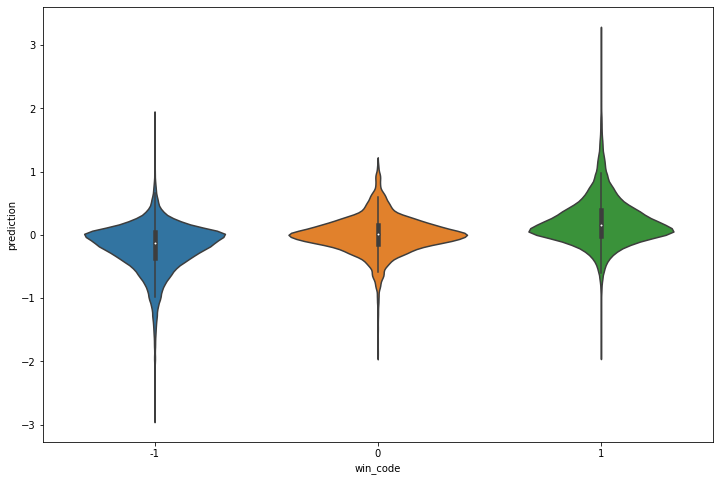

In [27]:
#plt.violinplot((df_testing_pos['win_code'], ), positions=[-1,0,1])
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.ylabel("prediction")
sns.violinplot(x=df_testing_pos['win_code'], y=pred_wins)

Overall, the distributions appear fairly similar, which is troubling at first glance. However, games start out with equal positions, meaning that most of our model's predictions will be draws, regardless of the outcome. Firstly, we can see that for the -1 violin plot, the data is skewed negative, while it's skewed positive for the 1 violin plot. This is favorable for us because this tells us that our model predicts more losses on average when the specific position ultimately ends on a loss. The same goes for the right most violin plot. For draws, we would expect an even distribution because there is no bias for the position. From this, we can further analyze our model's performance using a baseline model, but this is definitely reassuring.

### Comparison to a Traditional Model

Because of the problems associated with evaluating equal positions, it may be more useful to test our model by comparing it to another evaluation function. In traditional chess heuristics, pawns are given a weight of 1, knights and bishops have weights of 3, rooks have weight 5, and queens have weight 9. These weights are generally accepted as a good approximation of the value of each piece, so they are a good reference point. To evaluate our model, we can calculate predictions made with these traditional piece weights and compare the predictions to those made by our model. If our model is able to match or outperform the traditional heuristic, we'll consider it to be fairly accurate.

However, these models have very different scales; the maximum possible piece advantage for the traditional ranking system is much higher than the maximum advantage with our coefficients so we'll need to standardize the traditional model so that we can compare the two accurately.

In [28]:
def max_advantage(w):
    return 8*w[0] + 2*w[1] + 2*w[2] + 2*w[3] + w[4]

The max_advantage function computes the highest possible material advantage given a set of piece weights. This value will be used to standardize the piece weights in the two models.

In [29]:
traditional_values = np.array([1,3,3,5,9])
max_advantage(traditional_values)

39

In [30]:
our_values = model.params[2:7]
max_advantage(our_values)

2.833877313415456

The max advantage for the traditional system is 39, while for our model it is ~3, representing a large difference in scale. The function below will multiply the traditional weights by 3/39, converting them into weights with the same scale as our model. These weights can then be used to predict the outcome of a position.

In [31]:
def pred_with_piece_weights(X, piece_weights, model):
    model_scale = max_advantage(model.params[2:7])
    custom_scale = max_advantage(piece_weights)
    
    adj = piece_weights * model_scale / custom_scale
    
    pred_y = model.params[0] + model.params[1]*X['rating_diff'] + adj[0]*X['pawn_adv'] + adj[1]*X['knight_adv'] \
                + adj[2]*X['bishop_adv'] + adj[3]*X['rook_adv'] + adj[4]*X['queen_adv']
    
    return pred_y

With this function, we can predict the outcomes using the traditional model and compare it to ours.

In [32]:
trad_pred_wins = pred_with_piece_weights(df_testing_pos, traditional_values, model)

Traditional model squared error:

In [33]:
sklearn.metrics.mean_squared_error(df_testing_pos['win_code'], trad_pred_wins)

0.733595337125384

Our model square error:

This plot resembles the previous plot very closely indicating that there is a great deal of similarity between the two models. This is positive because our baseline model seems to be a good comparison.

In [34]:
sklearn.metrics.mean_squared_error(df_testing_pos['win_code'], pred_wins)

0.7279265050638417

Our model produces a very similar, but slightly lower square error when compared to the traditional mode, meaning that it is slightly better at evaluating positions accurately.

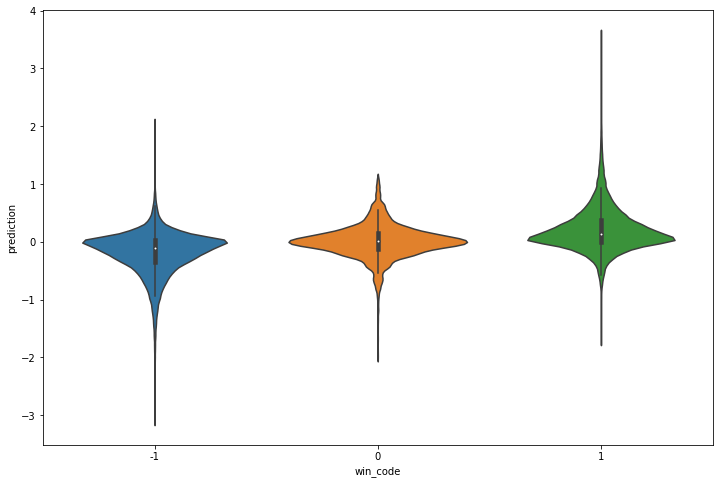

In [35]:
#plt.violinplot((df_testing_pos['win_code'], ), positions=[-1,0,1])
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.ylabel("prediction")
sns.violinplot(x=df_testing_pos['win_code'], y=trad_pred_wins)

This plot shows us the distributions for the traditional model. It closely resembles the previous plot on the prediction model and since we trust this traditional one, its positive to see similar results. Upon further statistical analysis, we can quantify this similarity.

Text(0.5, 1.0, 'Residual Distributions')

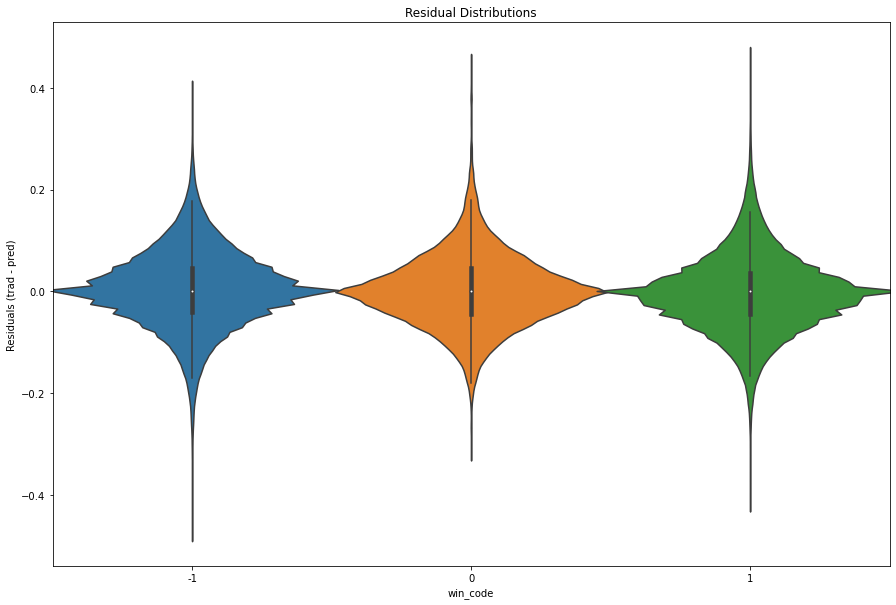

In [36]:
# Find residuals
resid = trad_pred_wins - pred_wins

# Plot residuals
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.ylabel("Residuals (trad - pred)")
sns.violinplot(x=df_testing_pos['win_code'], y=resid, width=1.1)
plt.title("Residual Distributions")

Another way to visualize the comparison between our model and the traditional model is by plotting the residuals between them. All three violin plots are centered around zero, which means that the models have similar predictions, which is means our model performs well relative to the traditional prediction. 

## Application: Basic Chess Engine

Now that we have a model that predicts the win rate based on a position, we can use this model to play chess by evaluating positions in real time. The 'evaluate' function below takes in a single board object and uses our model to determine the probability, P, that either player will win. The more positive P is, the greater the advantage for white; the more negative P is, the greater the advantage for black. If either player has won the game, the value of P will be +/-INF, indicating an absolute advantage. If P is 0, both players are equally likely to win, or the position is a draw.

In [60]:
# adv is an array containing the advantages of each of the pieces
def evaluate(board, adv, model):
    # If this position represents the end of the game, the model is not used since the outcome is known
    if (board.is_game_over()):
        result = board.result()
        # White wins
        if (result == '1-0'):
            return float('inf')
        # Draw
        elif (result == '1/2-1/2'):
            return 0
        # Black wins
        elif (result == '0-1'):
            return float('-inf')
    
    # Otherwise, the position is evaluated using the model
    # Inputs position info into the a dataframe that is input as X into the regression model
    # Assumes that the player and computer are equally rated, so first value is 0
    #position = pd.DataFrame([[0, adv[0], adv[1], adv[2], adv[3], adv[4], center_control(board)
                #]], columns=['rating_diff','pawn_adv','knight_adv','bishop_adv','rook_adv','queen_adv','center_control'])
    
    # P is computed using the model
    P = np.dot(model.params[2:7],adv) + model.params[7]*center_control(board)
    return P

To apply this evaluation function to a live game of chess, we'll use the minimax algorithm, a well known algorithm for zero-sum games. The algorithm takes an integer, depth, as a parameter. If the depth is 1, the algorithm will evaluate each of the player's available moves (in this case, using the model from the previous section) and select the one with the best outcome for the current player. This is akin to looking ahead one move. To look ahead more moves, the function can be called with a higher depth. For instance, calling minimax with a depth of 3 will recursively evaluate all variations for 3 moves into the future,  and make the moves with the best evaluation at each node, assuming optimal play for both players. This implementation uses alpha-beta pruning, which is an optimization that stops evaluating a position once the decision outcome is already known. For more information, see https://www.geeksforgeeks.org/minimax-algorithm-in-game-theory-set-4-alpha-beta-pruning/.

In [88]:
# This implementation returns a tuple of (move, value), with move being the optimal move and value being the evaluation
# of the position
def minimax(board, adv, depth, alpha, beta, model):
    # Base case is reached when depth = 0, or no moves possible
    # Returns raw evaluation with no move in the tuple
    if (depth == 0 or board.is_game_over()):
        return (chess.Move.null(), evaluate(board, adv, model))
    
    # If white to move, algorithm maximizes evaluation
    elif (board.turn == chess.WHITE):
        best = (chess.Move.null(), float("-inf"))
        
        for move in board.legal_moves:
            adv_temp = adv.copy()
            
            # If this move captures a piece, update temp array
            if (board.is_capture(move)):
                if (board.is_en_passant(move)):
                    piece_code = 1
                else:
                    piece_code = board.piece_type_at(move.to_square)
                adv_temp[piece_code-1] += 1
            
            # Makes move, then evaluates
            board.push(move)
            value = minimax(board, adv_temp, depth-1, alpha, beta, model)[1]
            
            # After evaluation, undoes move
            board.pop()
            
            if (value >= best[1]):
                best = (move, value)
            
            # alpha-beta pruning - stops loop if black can already guarantee a better outcome
            '''
            alpha = max(best[1], alpha)
            if (beta <= alpha):
                break'''
    
    # If black to move, algorithm minimizes evaluation
    else:   
        best = (chess.Move.null(), float("inf"))
        
        for move in board.legal_moves:
            adv_temp = adv.copy()
            
            # If this move captures a piece, updates the array
            if (board.is_capture(move)):
                if (board.is_en_passant(move)):
                    piece_code = 1
                else:
                    piece_code = board.piece_type_at(move.to_square) - 1
                adv_temp[piece_code] -= 1
                
            # Makes move, then evaluates
            board.push(move)
            value = minimax(board, adv_temp, depth-1, alpha, beta, model)[1]
            
            # After evaluation, undoes move
            board.pop()            
            
            if (value <= best[1]):
                best = (move, value)
            
            # alpha-beta pruning - stops loop if white can already guarantee a better outcome
            '''
            beta = min(best[1], beta)
            if (beta <= alpha):
                break'''
            
    return best

The play function starts a game of chess with the computer. The user inputs moves in standard algebraic notation (SAN), and the computer uses the regression model and the minimax algorithm to come up with a response. The python-chess library is used to store the moves in a board object, and to display the board after every move.

In [89]:
def play(model):
    board = chess.Board()
    adv = [0,0,0,0,0]
    print("--- NEW GAME ---")
    display(board)
    print("You play white. Enter moves in standard algebraic notation, or type 'r' to resign:")
    
    # This method checks for checkmate, stalemate, insufficient material, or draws by repetition
    while (not board.is_game_over()):
        player_move_san = input(">>> ")
        
        # This loop ensures that the player's move is valid
        move_verified = False
        while (not move_verified):
            # Resignation ends the game
            if (player_move_san == 'r'):
                print("Black wins")
                return
            
            try:
                player_move = board.parse_san(player_move_san)
                move_verified = True
                break;
            # If the move causes a ValueError, the player must re-enter a valid move
            except ValueError:
                print("Invalid move")
                player_move_san = input(">>> ")

        # Once player's move has been verified, push to the board and display
        board.push(player_move)
        display(board)
        
        print("Thinking...")
        
        # Here's where our model is used - the minimax function with depth=3 is used to decide the computer's move
        computer_move = minimax(board, adv, 3, float("-inf"), float("inf"), model)[0]
        
        # Update piece advantages
        if (board.is_capture(computer_move)):
            if (board.is_en_passant(computer_move)):
                piece_code = 1
            else:
                piece_code = board.piece_type_at(computer_move.to_square) - 1
            adv[piece_code] -= 1
        
        board.push(computer_move)
        display(board)
        
    # Once game is over, the state of the board is evaluated
    result = board.result()
    if (result == '1-0'):
        print("White wins")
    elif (result == '1/2-1/2'):
        print("Draw")
    elif (result == '0-1'):
        print("Black wins")
    return

### Sample Game:

In this game, and human player plays white and the computer (at depth=3) plays black.

--- NEW GAME ---


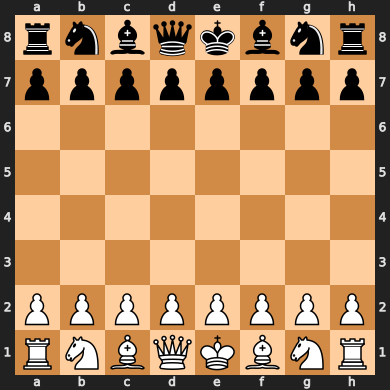

You play white. Enter moves in standard algebraic notation, or type 'r' to resign:
>>> e4


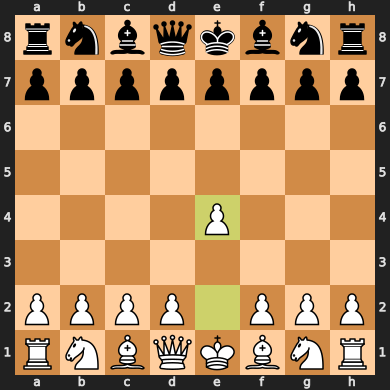

Thinking...


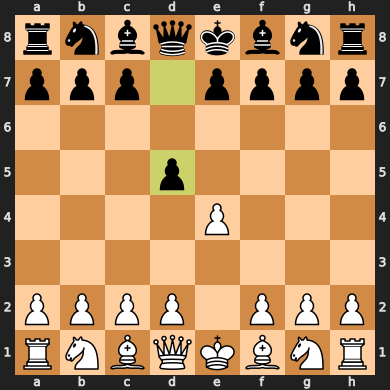

>>> exd5


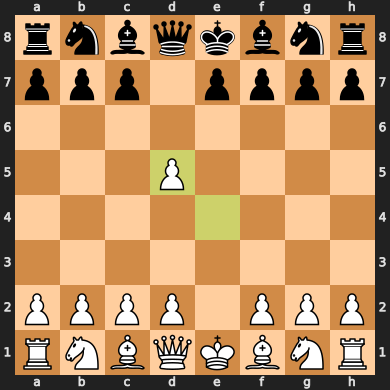

Thinking...


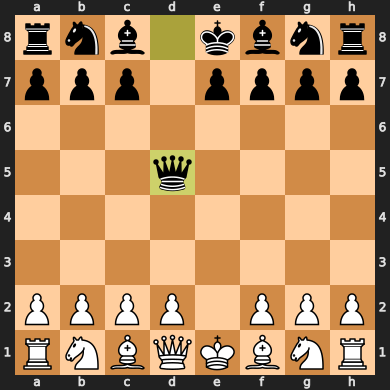

>>> Nc3


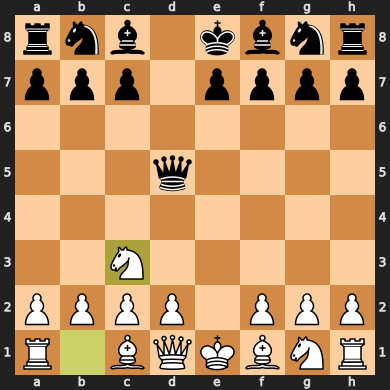

Thinking...


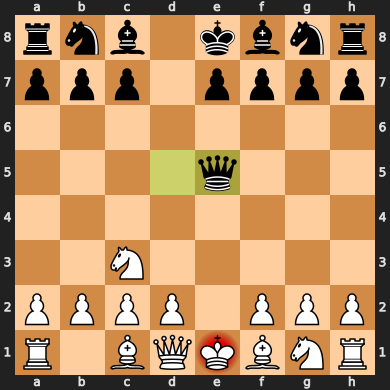

>>> Qe2


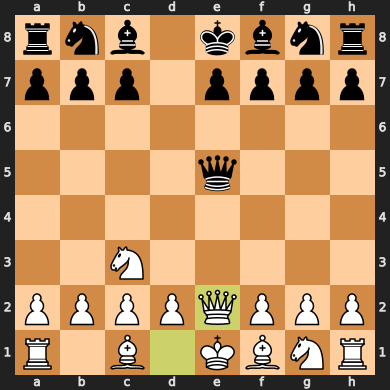

Thinking...


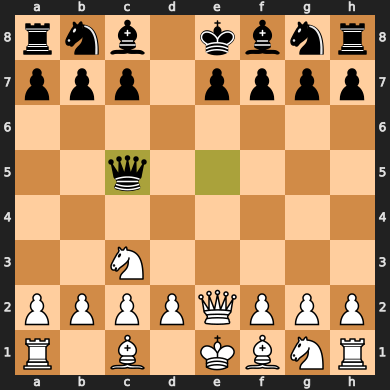

>>> d4


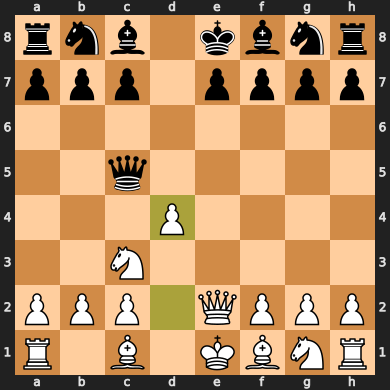

Thinking...


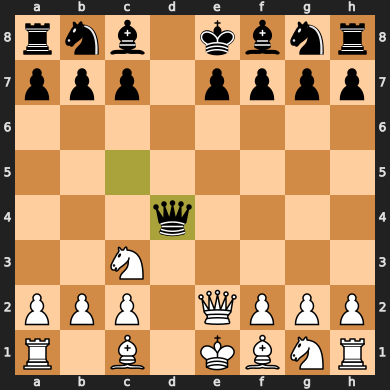

>>> Nf3


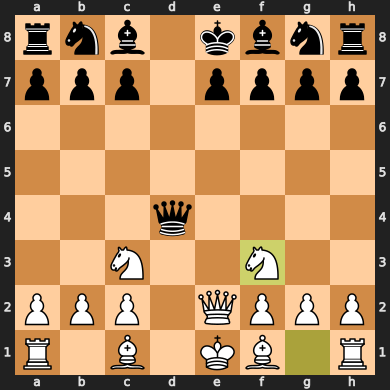

Thinking...


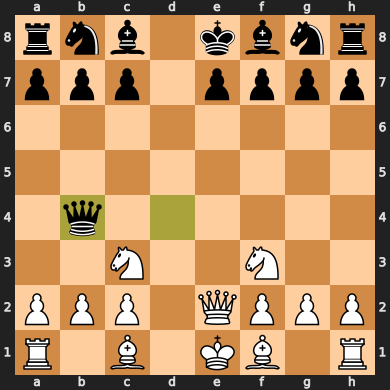

>>> a3


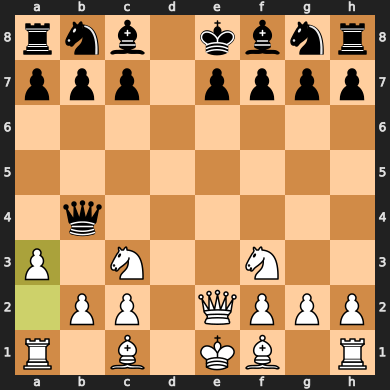

Thinking...


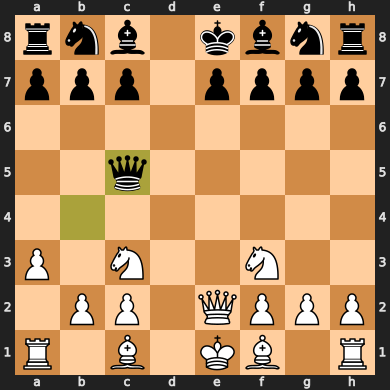

>>> Be3


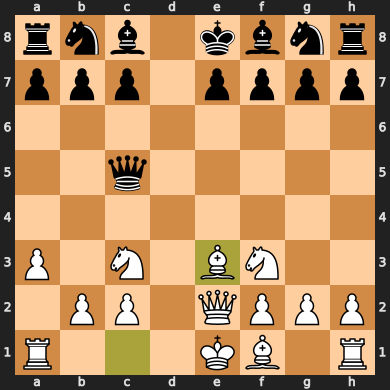

Thinking...


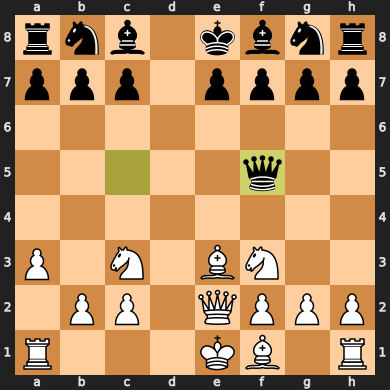

>>> r
Black wins


In [90]:
play(model)

With the minimax algorithm at depth 3, the computer is able to calculate basic tactics, such as captures, checking, and moving pieces out of danger. However, it does not look ahead to a significant extent, which can result in strange moves that a human player probably wouldn't make. In the example above, for instance, the computer (black) gets ahead on material and successfully moves its Queen out of harm's way when attacked, but it does not develop any its other pieces, giving white (the human player) a better position in the long term. A higher depth may result in better moves, but is much slower since the number of computations per move increases exponentially.